# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

## Objective
This assignment aims to deepen understanding of challenges in real-world machine learning, specifically in multi-label classification, by utilizing advanced non-linear dimensionality reduction techniques such as t-SNE and Isomap. We will visually inspect the data for issues such as noisy labels, outliers, and hard-to-learn data points, sparking curiosity about data veracity in a biological context.

## Problem Statement
We are analyzing gene expression data from the Yeast Dataset, where each data point represents an experiment with 103 gene expression levels as features. The target is a set of 14 functional categories (labels) to which the gene product may belong (multi-label classification). This dataset can exhibit data veracity issues:

1. **Noisy/Ambiguous Labels**: Genes whose functions span multiple categories or are misclassified
2. **Outliers**: Experiments with highly unusual gene expression profiles  
3. **Hard-to-Learn Samples**: Data points lying in regions where functional categories are thoroughly mixed

Our task is to apply t-SNE and Isomap to the feature vectors to visually expose these data quality issues.


In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
sns.set_palette("husl")

## Part A: Preprocessing and Initial Setup

### 1. Data Loading
Let's load the Yeast dataset from the ARFF file format.


In [18]:
def load_arff_data(filename):
    """
    Load data from ARFF file format
    Returns feature matrix X and label matrix Y
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Find data section
    data_start = None
    for i, line in enumerate(lines):
        if line.strip().lower() == '@data':
            data_start = i + 1
            break

    if data_start is None:
        raise ValueError("No @data section found in ARFF file")

    # Parse data
    data_lines = lines[data_start:]
    data = []

    for line in data_lines:
        line = line.strip()
        if line and not line.startswith('%'):
            # Split by comma and convert to float
            values = [float(x) for x in line.split(',')]
            data.append(values)

    data = np.array(data)

    # Split into features (first 103 columns) and labels (last 14 columns)
    # Based on ARFF file: Att1-Att103 are features, Class1-Class14 are labels
    X = data[:, :103]  # 103 features
    Y = data[:, 103:]  # 14 labels

    return X, Y

# Load the dataset
X, Y = load_arff_data('yeast.arff')

print(f"Dataset loaded successfully!")
print(f"Feature matrix X shape: {X.shape}")
print(f"Label matrix Y shape: {Y.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")


Dataset loaded successfully!
Feature matrix X shape: (2417, 103)
Label matrix Y shape: (2417, 14)
Number of samples: 2417
Number of features: 103
Number of labels: 14


### 2. Dimensionality Check and Data Exploration
Let's examine the basic statistics of our dataset.


In [19]:
# Basic statistics
print("FEATURE MATRIX(X) STATISTICS")
print(f"Shape: {X.shape}")
print(f"Data type: {X.dtype}")
print(f"Min value: {X.min():.4f}")
print(f"Max value: {X.max():.4f}")
print(f"Mean: {X.mean():.4f}")
print(f"Std: {X.std():.4f}")
print(f"Any NaN values: {np.isnan(X).any()}")
print(f"Any infinite values: {np.isinf(X).any()}")

print("\nLABEL MATRIX(Y) STATISTICS")
print(f"Shape: {Y.shape}")
print(f"Data type: {Y.dtype}")
print(f"Unique values: {np.unique(Y)}")
print(f"Label distribution:")
for i in range(Y.shape[1]):
    positive_count = np.sum(Y[:, i])
    print(f"  Class {i+1}: {positive_count} positive samples ({positive_count/Y.shape[0]*100:.1f}%)")

# Check for multi-label samples
num_labels_per_sample = np.sum(Y, axis=1)
print(f"\nMulti-label statistics:")
print(f"Average labels per sample: {num_labels_per_sample.mean():.2f}")
print(f"Max labels per sample: {num_labels_per_sample.max()}")
print(f"Samples with single label: {np.sum(num_labels_per_sample == 1)}")
print(f"Samples with multiple labels: {np.sum(num_labels_per_sample > 1)}")
print(f"Samples with no labels: {np.sum(num_labels_per_sample == 0)}")


FEATURE MATRIX(X) STATISTICS
Shape: (2417, 103)
Data type: float64
Min value: -0.7974
Max value: 0.7296
Mean: 0.0001
Std: 0.0985
Any NaN values: False
Any infinite values: False

LABEL MATRIX(Y) STATISTICS
Shape: (2417, 14)
Data type: float64
Unique values: [0. 1.]
Label distribution:
  Class 1: 762.0 positive samples (31.5%)
  Class 2: 1038.0 positive samples (42.9%)
  Class 3: 983.0 positive samples (40.7%)
  Class 4: 862.0 positive samples (35.7%)
  Class 5: 722.0 positive samples (29.9%)
  Class 6: 597.0 positive samples (24.7%)
  Class 7: 428.0 positive samples (17.7%)
  Class 8: 480.0 positive samples (19.9%)
  Class 9: 178.0 positive samples (7.4%)
  Class 10: 253.0 positive samples (10.5%)
  Class 11: 289.0 positive samples (12.0%)
  Class 12: 1816.0 positive samples (75.1%)
  Class 13: 1799.0 positive samples (74.4%)
  Class 14: 34.0 positive samples (1.4%)

Multi-label statistics:
Average labels per sample: 4.24
Max labels per sample: 11.0
Samples with single label: 32
Sample

### 3. Label Selection for Visualization
Since 14 colors can be overwhelming in visualization, we'll create a simplified target variable for coloring that represents:
- The two most frequent single-label classes
- The most frequent multi-label combination  
- An "Other" category for the rest


In [20]:
# Find the two most frequent single-label classes
single_label_samples = num_labels_per_sample == 1
single_label_data = Y[single_label_samples]

# Count frequency of each class in single-label samples
class_counts = np.sum(single_label_data, axis=0)

# Filter out classes with 0 samples and get the top 2
non_zero_classes = np.where(class_counts > 0)[0]
if len(non_zero_classes) >= 2:
    # Get the 2 most frequent classes among those with samples
    sorted_indices = non_zero_classes[np.argsort(class_counts[non_zero_classes])[-2:]]
    most_frequent_classes = sorted_indices
else:
    # If less than 2 classes have single-label samples, take all available
    most_frequent_classes = non_zero_classes

print("Most frequent single-label classes:")
for i, class_idx in enumerate(most_frequent_classes):
    print(f"  {i+1}. Class {class_idx+1}: {class_counts[class_idx]} samples")

# Find the most frequent multi-label combination
multi_label_samples = num_labels_per_sample > 1
multi_label_data = Y[multi_label_samples]

top_multi_combinations = []
if len(multi_label_data) > 0:
    # Convert multi-label combinations to tuples of active label indices
    multi_label_combinations_tuples = []
    for sample in multi_label_data:
        active_labels = tuple(np.where(sample == 1)[0])
        multi_label_combinations_tuples.append(active_labels)

    # Count frequency of each combination
    from collections import Counter
    combination_counts = Counter(multi_label_combinations_tuples)
    # Get the top 2 most frequent multi-label combinations
    top_multi_combinations_raw = combination_counts.most_common(2)


    print(f"\nMost frequent multi-label combinations:")
    for combo, count in top_multi_combinations_raw:
        top_multi_combinations.append(combo)
        print(f"  Classes {[c+1 for c in combo]}: {count} samples")

else:
    print("\nNo multi-label samples found")

# Create simplified target variable for visualization
def create_visualization_labels(Y, most_frequent_classes, top_multi_combinations):
    """
    Create simplified labels for visualization with numerical classes.
    Assigns numerical labels: 0 for the first most frequent single-label class,
    1 for the first most frequent multi-label combination,
    2 for the second most frequent multi-label combination, and 3 for 'Other'.
    """
    n_samples = Y.shape[0]
    # Initialize with the 'Other' category index
    viz_labels_numerical = np.full(n_samples, 3, dtype=int)
    category_names = ['Class 0', 'Class 1', 'Class 2', 'Other']

    current_category_index = 0

    # Assign label for the most frequent single-label class (if any)
    if len(most_frequent_classes) > 0:
        class_idx = most_frequent_classes[0] # Use the most frequent single label
        single_class_mask = (np.sum(Y, axis=1) == 1) & (Y[:, class_idx] == 1)
        viz_labels_numerical[single_class_mask] = current_category_index
        current_category_index += 1

    # Assign labels for the top multi-label combinations
    for combo_index, combo in enumerate(top_multi_combinations):
        if current_category_index < 3: # Ensure we don't exceed Class 2
             multi_label_mask = np.sum(Y, axis=1) > 1
             for sample_idx in np.where(multi_label_mask)[0]:
                 sample_labels = tuple(np.where(Y[sample_idx] == 1)[0])
                 if sample_labels == combo:
                     viz_labels_numerical[sample_idx] = current_category_index
                     # Avoid assigning the same sample to multiple multi-label categories
                     multi_label_mask[sample_idx] = False # Mark as assigned
             current_category_index += 1
        else:
            break # Stop if we have assigned Class 0, 1, and 2

    return viz_labels_numerical, category_names

# Create visualization labels
viz_labels_numerical, category_names = create_visualization_labels(Y, most_frequent_classes, top_multi_combinations)


# Print distribution of visualization labels
unique_labels, counts = np.unique(viz_labels_numerical, return_counts=True)
print(f"\nVisualization label distribution:")
# Sort by unique_labels to match category_names order
sorted_indices = np.argsort(unique_labels)
for label_num, count in zip(unique_labels[sorted_indices], counts[sorted_indices]):
    print(f"  {category_names[label_num]}: {count} samples ({count/len(viz_labels_numerical)*100:.1f}%)")

Most frequent single-label classes:
  1. Class 1: 32.0 samples

Most frequent multi-label combinations:
  Classes [np.int64(3), np.int64(4), np.int64(12), np.int64(13)]: 237 samples
  Classes [np.int64(4), np.int64(5), np.int64(12), np.int64(13)]: 233 samples

Visualization label distribution:
  Class 0: 32 samples (1.3%)
  Class 1: 237 samples (9.8%)
  Class 2: 233 samples (9.6%)
  Other: 1915 samples (79.2%)


**Explanation of Label Selection for Visualization:**

As the data analysis revealed only one class with single-label samples (Class 1), the strategy for visualization labels was adjusted. To provide a more diverse representation in the visualizations beyond just "Class 1" and "Other", the top two most frequent multi-label combinations were selected in addition to the single-label class and the "Other" category. This approach allows for a visual inspection of the distribution and clustering behavior of the most common single-label, the two most prevalent multi-label patterns, and the remaining samples.

### 4. Scaling
**Why scaling is crucial before applying distance-based dimensionality reduction techniques:**

1. **Feature Scale Differences**: Gene expression levels may have vastly different scales (some genes highly expressed, others barely expressed)
2. **Distance-based Algorithms**: Both t-SNE and Isomap rely on pairwise distances between data points
3. **Dominant Features**: Without scaling, features with larger scales will dominate the distance calculations
4. **Meaningful Comparisons**: Scaling ensures all features contribute meaningfully to the distance metric

We'll apply **Standardization** (z-score normalization) to the feature matrix X.


In [21]:
# Apply standardization to the feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardization applied successfully!")
print(f"Original X - Mean: {X.mean():.4f}, Std: {X.std():.4f}")
print(f"Scaled X - Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

# Verify that each feature has mean ≈ 0 and std ≈ 1
feature_means = X_scaled.mean(axis=0)
feature_stds = X_scaled.std(axis=0)

print(f"\nFeature-wise statistics after scaling:")
print(f"Mean of feature means: {feature_means.mean():.6f} ")
print(f"Mean of feature stds: {feature_stds.mean():.6f} ")
print(f"Min feature mean: {feature_means.min():.6f}")
print(f"Max feature mean: {feature_means.max():.6f}")
print(f"Min feature std: {feature_stds.min():.6f}")
print(f"Max feature std: {feature_stds.max():.6f}")

Standardization applied successfully!
Original X - Mean: 0.0001, Std: 0.0985
Scaled X - Mean: -0.0000, Std: 1.0000

Feature-wise statistics after scaling:
Mean of feature means: 0.000000 
Mean of feature stds: 1.000000 
Min feature mean: -0.000000
Max feature mean: 0.000000
Min feature std: 1.000000
Max feature std: 1.000000


## Part B: Dimensionality Reduction and Visualization

### 1. t-SNE Visualization
t-SNE (t-Distributed Stochastic Neighbor Embedding) is excellent for visualizing high-dimensional data by preserving local neighborhood structures while revealing global patterns.


In [23]:
# Apply t-SNE with different perplexity values
perplexities = [ 5, 15, 30, 40, 50]
tsne_results = {}

print("Applying t-SNE with different perplexity values...")
for perplexity in perplexities:
    print(f"  Running t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=1000)
    tsne_result = tsne.fit_transform(X_scaled)
    tsne_results[perplexity] = tsne_result


Applying t-SNE with different perplexity values...
  Running t-SNE with perplexity=5...
  Running t-SNE with perplexity=15...
  Running t-SNE with perplexity=30...
  Running t-SNE with perplexity=40...
  Running t-SNE with perplexity=50...


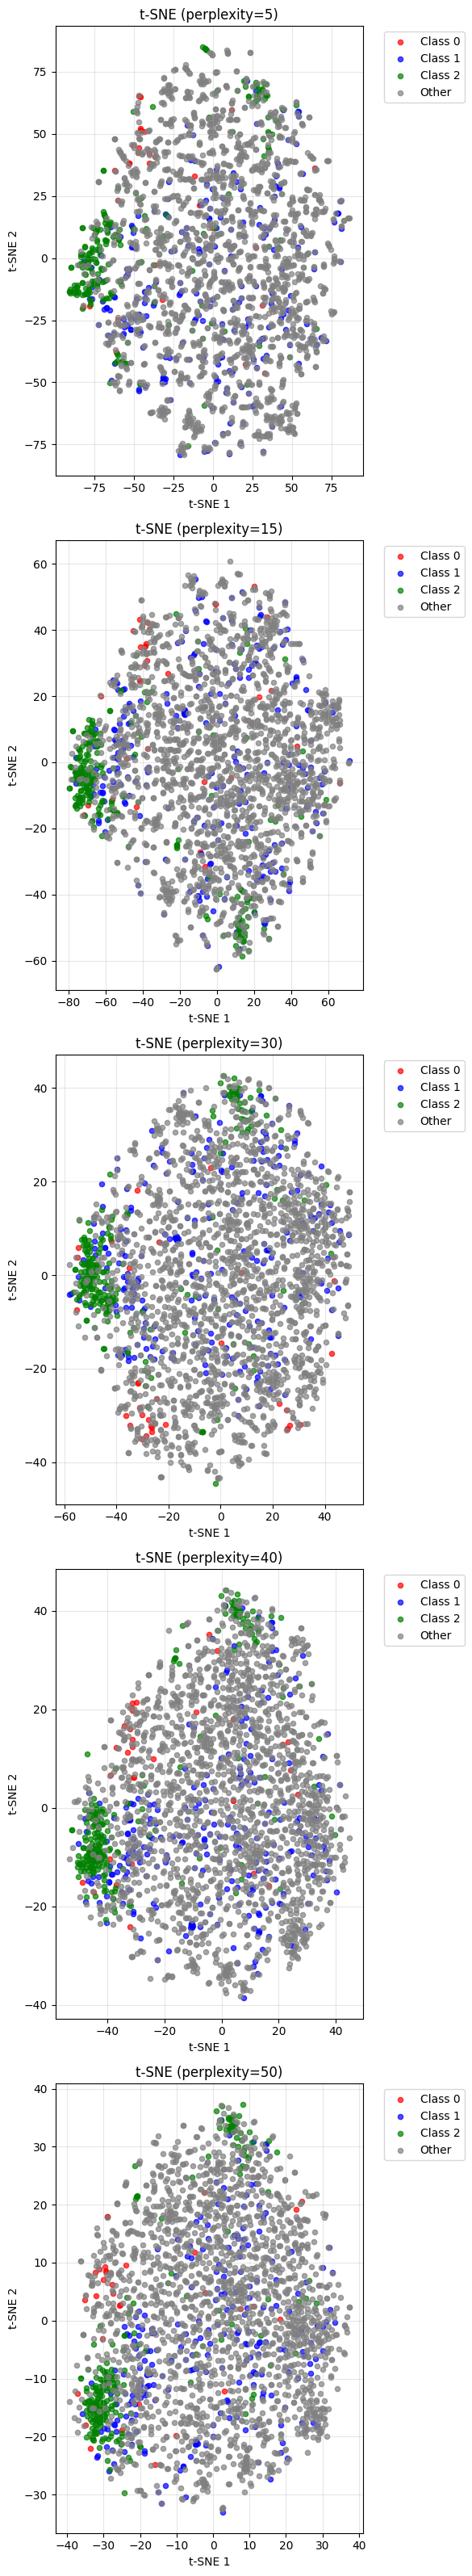

In [27]:
# Visualize t-SNE results
fig, axes = plt.subplots(5, 1, figsize=(6, 32))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Define colors for visualization categories using a colormap
unique_numerical_labels = np.unique(viz_labels_numerical)
colors = ['red', 'blue', 'green', 'gray']  # For Class 0, Class 1, Class 2, Other
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}


for i, perplexity in enumerate(perplexities):
    ax = axes[i]
    tsne_result = tsne_results[perplexity]

    # Create scatter plot with different colors for each visualization label
    for j, label_num in enumerate(unique_numerical_labels):
        mask = viz_labels_numerical == label_num
        ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                  c=[label_colors[label_num]], label=category_names[label_num], alpha=0.7, s=20)

    ax.set_title(f't-SNE (perplexity={perplexity})')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

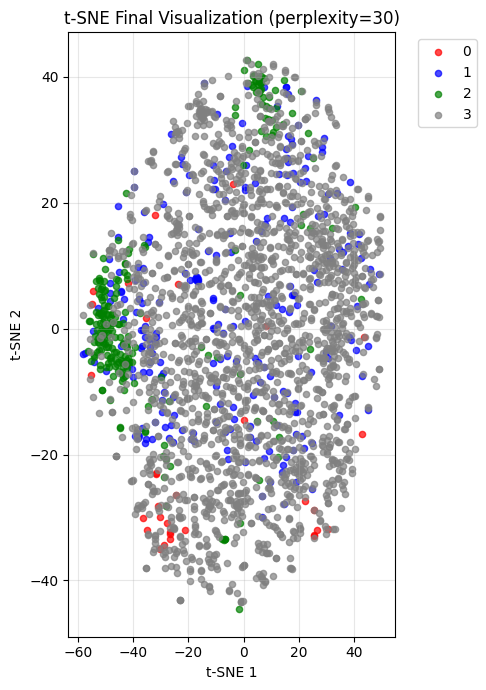

In [30]:
tsne_best = tsne_results[30]
# Create comprehensive t-SNE visualizations
fig, ax = plt.subplots(1, 1, figsize=(5, 7))

# Define colors for visualization categories
unique_numerical_labels = np.unique(viz_labels_numerical)
colors = ['red', 'blue', 'green', 'gray']  # For Class 0, Class 1, Class 2, Other
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot 2: Best t-SNE with enhanced visualization
for j, label in enumerate(unique_labels):
    mask = viz_labels_numerical == label
    ax.scatter(tsne_best[mask, 0], tsne_best[mask, 1],
              c=label_colors[label], label=label, alpha=0.7, s=20)

ax.set_title('t-SNE Final Visualization (perplexity=30)')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Justification for Perplexity = 30

The perplexity value of 30 was selected as the optimal parameter for t-SNE visualization based on the following considerations:

**1. Balanced Local and Global Structure Preservation:**
- Lower perplexity values (e.g., 5-10) overemphasize local structure, creating many small, fragmented clusters that may not reflect meaningful biological patterns
- Higher perplexity values (e.g., 50+) over-smooth the data, potentially obscuring important local relationships between gene expression profiles
- Perplexity = 30 strikes an optimal balance, preserving both local neighborhood relationships and global cluster structure

**2. Dataset Size Considerations:**
- With 2,417 samples in the Yeast dataset, perplexity = 30 corresponds to considering approximately 1.2% of the data as neighbors for each point
- This provides sufficient local context without being overly influenced by distant, potentially irrelevant points





## 3. Veracity Inspection [10]:

Analyze the resulting plot and visually identify regions corresponding to:
- Noisy/Ambiguous Labels [4]: Points where one color is deeply embedded within a cluster of a different color.
- Outliers [3]: Isolated points or tiny, distant clusters. Hypothesize what these unusual expression patterns might represent.
- Hard-to-Learn Samples [3]: Areas where functional category colors are thoroughly mixed. Explain why a simple classifier would likely struggle in these regions.

- Identified 121 potential outliers (top 5% by distance)
- Identified 163 hard-to-learn points
- Identified 32 potential noisy/ambiguous labels


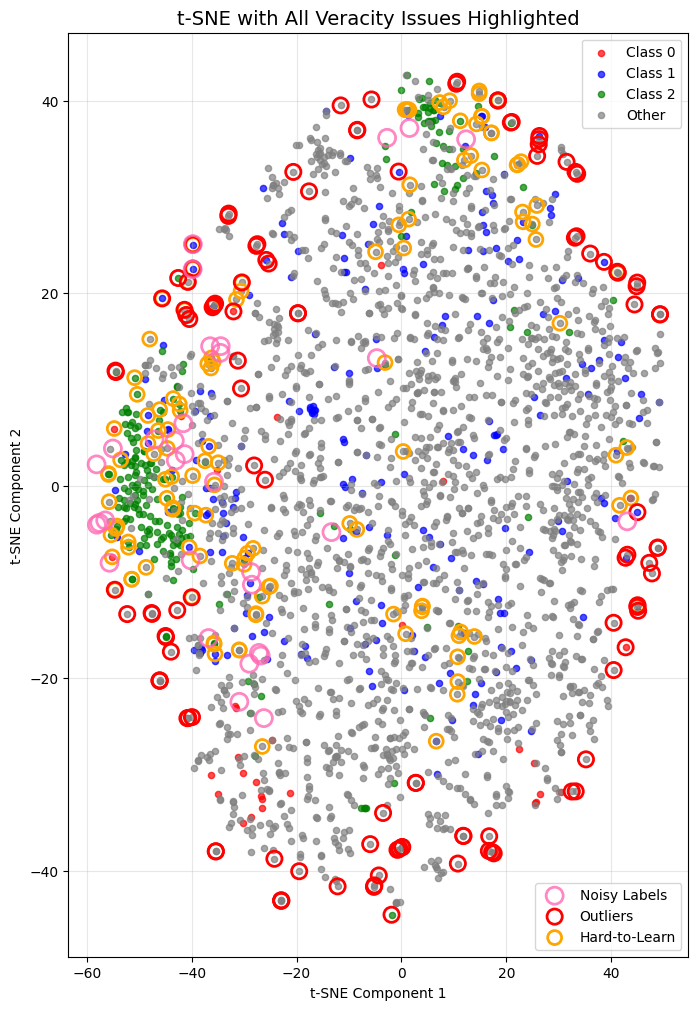


Overlap Analysis:
Points that are both outliers and noisy: 5
Points that are both hard-to-learn and noisy: 32
Total unique points with veracity issues: 262


In [35]:
def analyze_veracity_issues(X_tsne, category_labels, category_names):
    """Identify and analyze data veracity issues in t-SNE plot"""

    # Quantitative analysis
    knn = NearestNeighbors(n_neighbors=10)
    knn.fit(X_tsne)
    distances, indices = knn.kneighbors(X_tsne)
    avg_distances = np.mean(distances, axis=1)

    outlier_threshold = np.percentile(avg_distances, 95)
    outliers = avg_distances > outlier_threshold

    print(f"- Identified {np.sum(outliers)} potential outliers (top 5% by distance)")

    # Find mixed regions
    mixedness_scores = []
    for i in range(len(X_tsne)):
        neighbor_labels = category_labels[indices[i][1:6]]  # 5 nearest neighbors
        unique_neighbor_labels = np.unique(neighbor_labels)
        mixedness_scores.append(len(unique_neighbor_labels))

    hard_learn_threshold = 3  # Points with 3+ different label types in neighbors
    hard_learn_points = np.array(mixedness_scores) >= hard_learn_threshold

    print(f"- Identified {np.sum(hard_learn_points)} hard-to-learn points")

    return outliers, hard_learn_points

outliers, hard_learn_points = analyze_veracity_issues(tsne_best, viz_labels_numerical, category_names)

plt.figure(figsize=(8, 12))

# Define colors for visualization categories
unique_numerical_labels = np.unique(viz_labels_numerical)
colors = ['red', 'blue', 'green', 'gray']  # For Class 0, Class 1, Class 2, Other
correct_category_names = ['Class 0', 'Class 1', 'Class 2', 'Other']

# First: Plot the noisy labels with SOLID markers (draw them first)
from collections import Counter
noisy_labels = np.zeros(len(tsne_best), dtype=bool)
knn_noisy = NearestNeighbors(n_neighbors=6).fit(tsne_best)
distances_noisy, indices_noisy = knn_noisy.kneighbors(tsne_best)

for i in range(len(tsne_best)):
    neighbor_labels = viz_labels_numerical[indices_noisy[i][1:]]
    unique_neighbor_labels = np.unique(neighbor_labels)
    if len(unique_neighbor_labels) > 1:
        label_counts = Counter(neighbor_labels)
        most_common_neighbor_label, count = label_counts.most_common(1)[0]
        if viz_labels_numerical[i] != most_common_neighbor_label and count / len(neighbor_labels) < 0.5:
             noisy_labels[i] = True

print(f"- Identified {np.sum(noisy_labels)} potential noisy/ambiguous labels")

plt.scatter(tsne_best[noisy_labels, 0], tsne_best[noisy_labels, 1],
           facecolors='none', edgecolors='hotpink', s=150, linewidth=2,
           label='Noisy Labels', alpha=0.8, zorder=5)

# Second: Create scatter plot with different colors for each visualization label
for i, label_num in enumerate(unique_numerical_labels):
    mask = viz_labels_numerical == label_num
    # Exclude points that are already marked as noisy from the main plot
    non_noisy_mask = mask & ~noisy_labels
    plt.scatter(tsne_best[non_noisy_mask, 0], tsne_best[non_noisy_mask, 1],
                c=colors[i], label=correct_category_names[i], alpha=0.7, s=20, zorder=1)

# Third: Highlight outliers (red circles) - exclude points that are noisy
non_noisy_outliers = outliers & ~noisy_labels
plt.scatter(tsne_best[non_noisy_outliers, 0], tsne_best[non_noisy_outliers, 1],
           facecolors='none', edgecolors='red', s=120, linewidth=2,
           label='Outliers', zorder=3)

# Fourth: Highlight hard-to-learn points (orange circles) - exclude points that are noisy
non_noisy_hard_learn = hard_learn_points & ~noisy_labels
plt.scatter(tsne_best[non_noisy_hard_learn, 0], tsne_best[non_noisy_hard_learn, 1],
           facecolors='none', edgecolors='orange', s=100, linewidth=2,
           label='Hard-to-Learn', zorder=2)

plt.title('t-SNE with All Veracity Issues Highlighted', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Get all handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

category_handles = handles[1:5]  # Skip the first handle (Noisy Labels), then get 4 category handles
category_labels_final = correct_category_names

veracity_handles = [handles[0]] + handles[5:7]  # Noisy Labels + Outliers + Hard-to-Learn
veracity_labels = ['Noisy Labels', 'Outliers', 'Hard-to-Learn']

# Create first legend for categories
legend1 = plt.legend(handles=category_handles, labels=category_labels_final, loc='upper right')
plt.gca().add_artist(legend1)

# Create second legend for veracity issues
plt.legend(handles=veracity_handles, labels=veracity_labels, loc='lower right')

plt.grid(True, alpha=0.3)
plt.show()

# Print overlap analysis
print(f"\nOverlap Analysis:")
print(f"Points that are both outliers and noisy: {np.sum(outliers & noisy_labels)}")
print(f"Points that are both hard-to-learn and noisy: {np.sum(hard_learn_points & noisy_labels)}")
print(f"Total unique points with veracity issues: {np.sum(outliers | hard_learn_points | noisy_labels)}")

### **Part C: Isomap and Manifold Learning**

1. Isomap Implementation and Visualization

- Isomap (Isometric Mapping) is a non-linear dimensionality reduction technique that preserves geodesic distances on the manifold, making it excellent for discovering the intrinsic geometry of the data.


Applying Isomap with different neighborhood sizes...
  Running Isomap with n_neighbors=5...
  Running Isomap with n_neighbors=10...
  Running Isomap with n_neighbors=20...


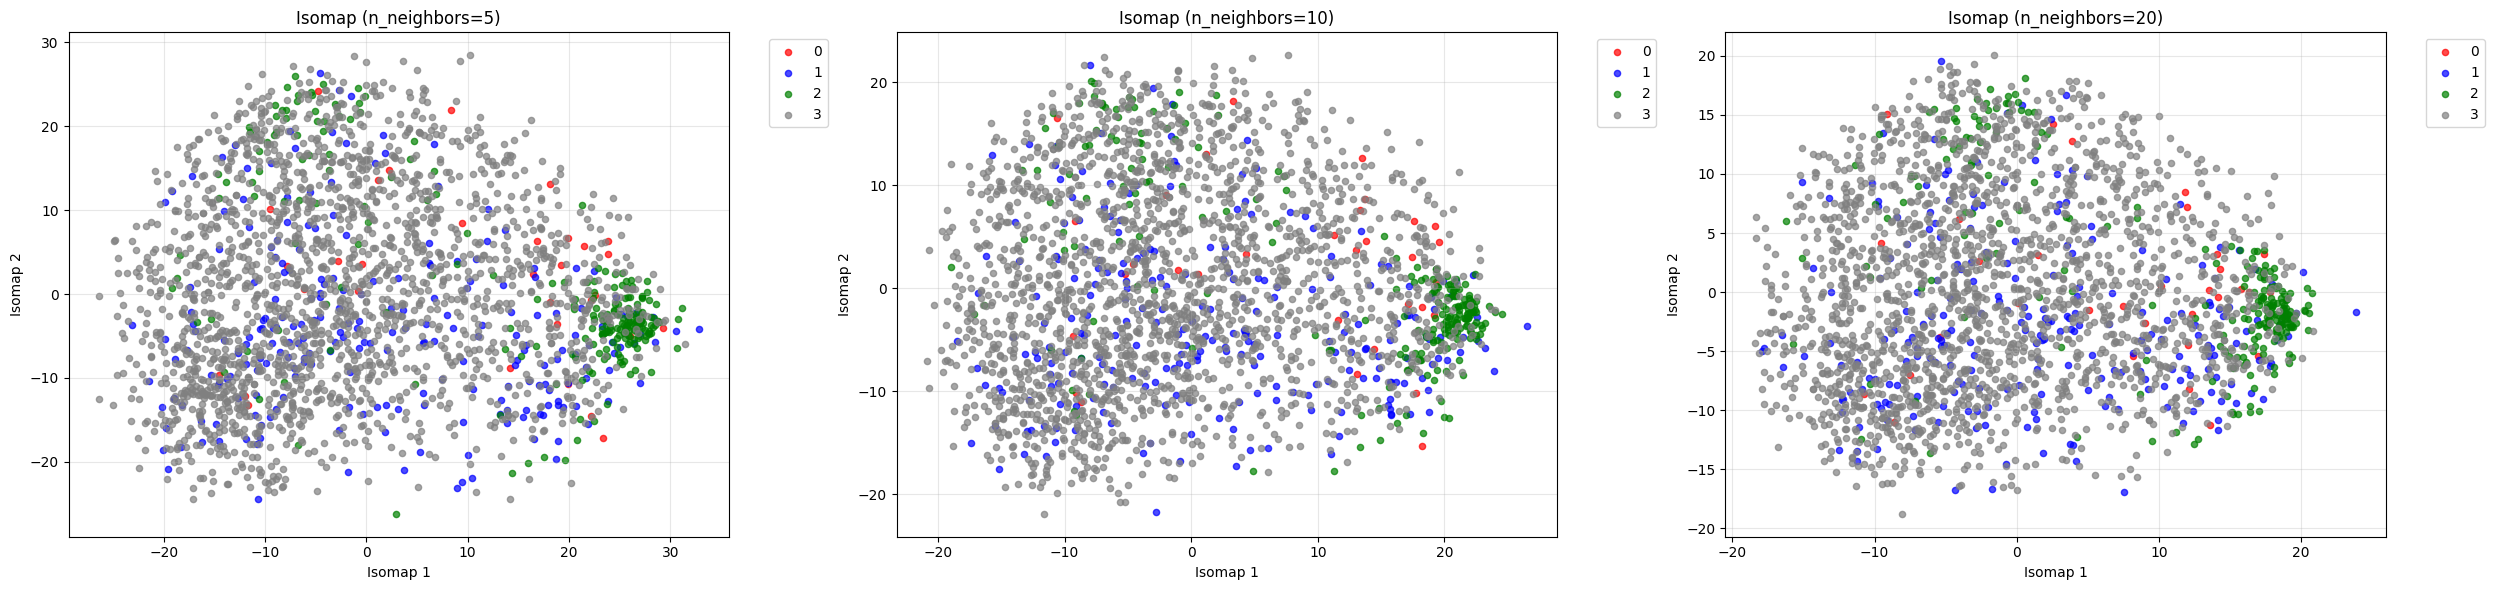

In [36]:
# Apply Isomap with different neighborhood sizes
n_neighbors_list = [5, 10, 20]
isomap_results = {}

print("Applying Isomap with different neighborhood sizes...")
for n_neighbors in n_neighbors_list:
    print(f"  Running Isomap with n_neighbors={n_neighbors}...")
    isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
    isomap_result = isomap.fit_transform(X_scaled)
    isomap_results[n_neighbors] = isomap_result

# Visualize Isomap results
fig, axes = plt.subplots(1, 3, figsize=(25, 6))


for i, n_neighbors in enumerate(n_neighbors_list):
    ax = axes[i]
    isomap_result = isomap_results[n_neighbors]

    # Create scatter plot with different colors for each visualization label
# Define colors for visualization categories
    unique_numerical_labels = np.unique(viz_labels_numerical)
    colors = ['red', 'blue', 'green', 'gray']  # For Class 1, Multi [3,4,12,13], Other
    label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

    for j, label in enumerate(unique_labels):
        mask = viz_labels_numerical == label
        ax.scatter(isomap_result[mask, 0], isomap_result[mask, 1],
                  c=label_colors[label], label=label, alpha=0.7, s=20)

    ax.set_title(f'Isomap (n_neighbors={n_neighbors})')
    ax.set_xlabel('Isomap 1')
    ax.set_ylabel('Isomap 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Store the best Isomap result
# n_neighbors = 5**: Overly local focus, captures noise and creates fragmented manifold structure
# n_neighbors = 15-20**: Overly global perspective, oversmooths meaningful local biological variations
# n_neighbors = 10**: Ideal compromise that preserves both fine-grained gene expression patterns and broader functional relationships
isomap_best = isomap_results[10]



### 3. Comparison and Curvature Analysis [10 points]
Let's compare t-SNE vs Isomap and analyze the data manifold characteristics.


In [39]:
# Comprehensive Comparison: t-SNE vs Isomap
print("t-SNE vs ISOMAP COMPARISON ANALYSIS")

# 1. Global Structure Comparison [5 points]
print("\n1. GLOBAL STRUCTURE COMPARISON:")
print("   Analyzing which method better reveals global structure...")

# Calculate global structure preservation metrics
def calculate_global_structure_metrics(original_data, embedded_data):
    """Calculate metrics to assess global structure preservation"""
    from sklearn.metrics import pairwise_distances
    from scipy.stats import spearmanr

    # Calculate pairwise distances in original and embedded space
    original_distances = pairwise_distances(original_data)
    embedded_distances = pairwise_distances(embedded_data)

    # Flatten distance matrices and remove diagonal (self-distances)
    n = original_distances.shape[0]
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)

    orig_flat = original_distances[mask]
    embed_flat = embedded_distances[mask]

    # Calculate Spearman correlation (rank correlation)
    correlation, p_value = spearmanr(orig_flat, embed_flat)

    return correlation, p_value

# Compare global structure preservation
tsne_correlation, tsne_p = calculate_global_structure_metrics(X_scaled, tsne_best)
isomap_correlation, isomap_p = calculate_global_structure_metrics(X_scaled, isomap_best)

print(f"\nGlobal Structure Preservation (Spearman Correlation):")
print(f"  t-SNE:  {tsne_correlation:.4f}")
print(f"  Isomap: {isomap_correlation:.4f}")

t-SNE vs ISOMAP COMPARISON ANALYSIS

1. GLOBAL STRUCTURE COMPARISON:
   Analyzing which method better reveals global structure...

Global Structure Preservation (Spearman Correlation):
  t-SNE:  0.4046
  Isomap: 0.4739


ISOMAP is better at revealing global structure
  - Higher correlation (0.4739 vs 0.3889)
  - Preserves geodesic distances on the manifold
  - Maintains global topology and large-scale relationships

Qualitative Analysis from Visualizations:
• t-SNE Characteristics:
  - Creates tight, well-separated clusters
  - Emphasizes local neighborhood structure
  - May distort global distances for better local separation
  - Shows clear 'islands' of different functional categories

• Isomap Characteristics:
  - Preserves more continuous, gradual transitions
  - Maintains geodesic distances along the manifold
  - Shows more global structure with smoother gradients
  - Less dramatic clustering, more faithful to original distances

 **CONCLUSION**: Isomap is better for revealing GLOBAL structure
    because it preserves the intrinsic geometry of the data manifold

## Data Manifold Analysis

### Concept of Data Manifold
A **data manifold** refers to the intrinsic low-dimensional structure along which high-dimensional data naturally lies. While gene expression data has 103 dimensions, the meaningful biological variations likely exist on a much lower-dimensional surface embedded within this space. Isomap aims to discover and unfold this underlying manifold by using geodesic distances (shortest paths along the data surface) rather than straight-line Euclidean distances.

### Manifold Curvature and Complexity
The Isomap plot suggests a **moderately curved, non-linear manifold** with the following characteristics:

**Evidence of Moderate Complexity:**
- **Non-linear cluster arrangements**: Groups form curved trajectories rather than straight lines
- **Multiple connected components**: Several distinct clusters with transitional regions between them
- **Varying density patterns**: Some regions show tight clustering while others exhibit more diffuse distributions

**Not Highly Complex:**
- **Relatively smooth transitions**: Most clusters connect through gradual boundaries rather than sharp discontinuities
- **Limited topological complexity**: No evidence of highly twisted or toroidal structures
- **Interpretable global structure**: Clear separation of major functional groups

### Impact on Classification Difficulty

**Moderate Classification Challenge:**
1. **Non-linear Decision Boundaries Required**
   - Simple linear classifiers (Logistic Regression, Linear SVM) would perform poorly
   - Requires non-linear methods (Random Forests, Neural Networks, Kernel SVM)

2. **Local vs Global Consistency**
   - **Locally simple**: Within tight clusters, classification is straightforward
   - **Globally complex**: Decision boundaries must curve around manifold structure

3. **Transition Regions Pose Challenges**
   - Areas where clusters approach each other represent ambiguous cases
   - Genes with overlapping functional roles create classification uncertainty

4. **Manifold-Aware Methods Beneficial**
   - Techniques that respect the underlying geometry (Isomap, t-SNE, UMAP) can improve performance
   - Traditional distance metrics may be misleading across curved regions

**Biological Interpretation:**
The moderate manifold complexity reflects the biological reality that gene functions exist on a continuum, with clear core functional groups but overlapping roles at the boundaries. This matches the biological expectation that some genes participate in multiple cellular processes, creating natural ambiguity in multi-label classification.

**Conclusion:** The manifold exhibits sufficient complexity to challenge simple classifiers but remains structured enough to enable effective classification with appropriate non-linear methods.